# CBB 500 Final project
# Gene Tree Clustering with Modularity
Species trees provide foundational data for biological studies from ecology to epidemiology. There has been a boom in software to accurately estimate species trees as sequencing techniques and technology have expanded the types, and reduced the per base-pair cost, of sequencing. One, increasingly popular sequencing technique is the creation of reduced representation libraries, primarily with restriction site-associated DNA sequencing (RADseq, Baird et al, 2008). In this family of methods hundreds to thousands of short (~30-600bp) loci are generated that are often not present for all taxa. Therfore these loci have information to connect only a handful of taxa and their short length implies low phylogenetic signal; often RAD loci with more than one SNP per locus are discarded or subsampled. Hence, gene tree estimation from these loci not only lacks precision but often is inaccurate. Because gene trees serve as the input data into many species tree estimation programs, accurate gene tree estimation is necessary for species tree construction. 

It has long been known that different genes have different evolutionary history due to 1) incomplete lineage sorting (coalescent stochasticity), 2) horizontal gene transfer (including hybridization/introgression), and 3) gene duplication and extinction (reviewed in Maddison, 1997). For these reasons, as well among-site rate heterogeneity (e.g. second vs. third codon position), concatenating multiple loci and treating them as a single evolutionary unit can be not only wrong, but "positively midleading" (Roch and Steel, 2014); showing strong support for incorrect phylogenetic hypotheses. Hence, discordance among gene trees and the low signal in RADseq loci pose serious challenges to species tree construction.

Recent studies have found that naively (randomly) binning loci that share similar evolutionary histories into "supergenes" results in more accurate gene tree estimation, and, in turn, more accurate species tree estimation (Bayzid and Warnow, 2013; Jarvis et al, 2014; Mirarab et al. 2014). While this process makes progress in species tree estimation through combining information, it neglects much of the rich biological information present in genes and their repsective gene trees. Here I present Gene Tree Clustering with Modularity (GTCM), a method to cluster genes using the information in their gene trees. The Robinson-Foulds distance (Robinson and Foulds, 1981) is used to measure the similarity in gene trees, gene trees are then clustered through greedy modularity maximization (Louvain method, Blondell et al, 2008), and, finally, gene clusters are extracted and concatenated for species tree estimation.

## 0. Load libraries and define functions*
*Functions that do not require motivation (i.e. from previous homework, used for bookkeeping or parsing)

In [102]:
# I/O and basics
import numpy as np
import codecs, json, sys, os, csv, re
from shutil import move
from StringIO import StringIO
from tqdm import tqdm_notebook
import pandas as pd
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import seaborn as sns
# Bioinformatics
import ete3 as ete
from Bio import AlignIO, Alphabet
from Bio.Nexus import Nexus
import dendropy

In [4]:
def listabs(directory):
    '''Returns the absolute path of all items in a directory
    
    Parameters
    ----------
    directory : path to directory'''
    return [os.path.join(directory, filename) for filename in os.listdir(directory)]

In [5]:
class Vividict(dict):
    '''An inifinitely nestable dictionary created by user Aaron Hall on StackOverflow'''
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value

In [6]:
def round_up_to_even(f):
    '''Rounds an integer f up to the nearest even number
    
    Parameters
    ----------
    f: int'''
    if f%2==0: return f
    else: return f+1

In [178]:
def flatten(l):
    '''Creates a 1-D list from a list of sublists
    
    Parameters
    ----------
    l : a list'''
    return [item for sublist in l for item in sublist]

In [8]:
def compute_affinity_matrix(D, kernel_type, sigma=None, k=None):
    '''Construct an affinity matrix from a distance matrix via gaussian kernel.

    Inputs:
        D               a numpy array of size n x n containing the distances between points
        kernel_type     a string, either "gaussian" or "adaptive".
                            If kernel_type = "gaussian", then sigma must be a positive number
                            If kernel_type = "adaptive", then k must be a positive integer
        sigma           the non-adaptive gaussian kernel parameter
        k               the adaptive kernel parameter
    Outputs:
        W       a numpy array of size n x n that is the affinity matrix'''
    # Check if all affinity conditions are met
    if not ((kernel_type=='gaussian' and sigma>0) or ((kernel_type=='adaptive' and type(k)==int and k>0))):
        print("Kernel must be of type 'gaussian' with sigma>0, or 'adaptive' with k a positive integer.")
        return      
    # Compute with Gaussian kernel
    elif kernel_type=='gaussian':
        W = np.exp(-np.square(distances)/(2*sigma**2))     
    # Compute with adaptive kernel        
    elif kernel_type=='adaptive':
        W = np.zeros(shape=np.shape(D))
        for i in range(np.shape(D)[0]):
            sigma = np.sort(D[i])[k]
            if sigma==0: sigma=1e-9
            W[i] = np.exp(-np.square(D[i])/(2*sigma**2))
        
    # return the affinity matrix
    return np.asarray(W)

In [9]:
def dict_modularity(affinity_matrix, assignments):
    '''Calculates modularity
    
    Parameters
    ----------
    affinity_matrix : an affinity matrix as an ndarry
    assignments : a dictionary where the keys are indicies 
    and values are cluster assignments'''
    modularity=0
    m = np.sum(affinity_matrix)
    # Loop over all clusters
    for l in set(assignments.values()):
        c_pts = [node for node, cluster in assignments.items() if cluster == l]
        # Get cluster's slice of affinity matrix
        l_aff = affinity_matrix[np.ix_(c_pts,c_pts)]
        # Calculate degree. Note that we're adding each 
        # point again for the self loops
        degree = np.sum([np.sum(l_aff[x])+l_aff[x,x] for x in range(len(c_pts))])
        # Calculate addition to modularity of cluster
        l_mod = (np.sum(l_aff)/m) - (degree/(2*m))**2
        modularity+=l_mod

    return modularity

In [10]:
def phase_one(clust_affinity, k, merge_tol, verbose=True):
    '''Phase One of the two phase modularity clustering algorithm. In this 
    phase, greedily form clusters, using a random ordering of elements
    Inputs:
        clust_affinity  a numpy array of size n x n containing the affinities between clusters
        k               the number of nearest neighbors to check
        merge_tol       the tolerance for merging
    Outputs:
        clust_assignments   a dictionary where keys are 0 ... n-1 and with values are 0 ... c-1 where 
                            clust_assignments[i] = j if point i is in cluster j
                            Hint: the condition that the values are 0...c-1 need only be true upon returning
        modularity_increase a float that keeps track of the increase in modularity  during this phase'''
    # Initialize random clustering and calculate modularity
    clust_assignments = dict(zip(range(len(clust_affinity)), range(len(clust_affinity))))   
    init_mod = dict_modularity(clust_affinity, clust_assignments)
    modularities = [init_mod]
    if verbose: print('Initial modularity: %f') % (init_mod)
    
    # Initialize nested dictionary of clusterings
    clustdicts = Vividict()
    clustdicts['i00']['clustering'] = dict(clust_assignments)
    clustdicts['i00']['modularity'] = init_mod
    clustdicts['i00']['n_clusters'] = len(clust_affinity)
    # Set initial merge tolerance
    new_merge_tol = 0
    # Initialize loop
    stationary = False
    i = 1
    while stationary==False and len(list(set(clust_assignments.values())))>1:
        if verbose: print('Merge tolerance: %.7f') % (new_merge_tol)
        # Set initial total modularity increase to be 0
        mod_increase = 0
        for x in tqdm_notebook(np.random.permutation(clust_assignments.keys()), leave=verbose):
            # Set initial modularity difference for x
            pointmoddiff=0
            # Check k nearest neighbors for greatest modularity increase
            for n in np.argsort(clust_affinity[x])[::-1][1:k+1]:
                newmoddiff = modularity_diff(v=x, clust=clust_assignments[n], clust_affinity=clust_affinity, 
                                             clust_assignment=clust_assignments)
                if newmoddiff > pointmoddiff: 
                    pointmoddiff = newmoddiff
                    moveto = clust_assignments[n] # Keep track of cluster
            if pointmoddiff > new_merge_tol: # If increase > tolerance, move x
                clust_assignments[x] = moveto
                mod_increase += pointmoddiff
        clustdicts['i'+str(i).zfill(2)]['clustering'] = dict(clust_assignments)
        clustdicts['i'+str(i).zfill(2)]['modularity'] = dict_modularity(clust_affinity, clust_assignments)
        clustdicts['i'+str(i).zfill(2)]['n_clusters'] = len(list(set(clust_assignments.values())))
        # Set merge tolerance to fraction of updated modularity
        new_merge_tol = merge_tol*dict_modularity(clust_affinity, clust_assignments)
        if verbose: 
            print('There are %d clusters\n\tModularity: %.10f\n\tModulary increase=%f') % \
            (len(list(set(clust_assignments.values()))), dict_modularity(clust_affinity, 
                                                        clust_assignments), mod_increase)
        # Exit when starting and ending dict are the same
        if clust_assignments==clustdicts['i'+str(i-1).zfill(2)] or mod_increase==0:
            stationary=True
            del clustdicts['i'+str(i).zfill(2)]
            if verbose: print('Reached stationarity')
        i+=1
    # Calculate increase in modularity
    modularity_increase = dict_modularity(clust_affinity,clust_assignments)-init_mod
    return clustdicts, modularity_increase

In [11]:
def phase_two(clust_affinity, clust_assignments, verbose=True):
    '''
    Phase Two of the two phase modularity clustering algorithm.
    In this phase, combine merged clusters into a larger graph

    Inputs:
        clust_affinity      a numpy array of size n x n containing the affinities between points
        clust_assignments   a dictionary where keys are 0 ... n-1 and with values are 0 ... c-1 where 
                            clust_assignments[i] = j if point i is in cluster j
    Outputs:
        new_clust_affinity  a numpy array of size c x c containing the affinities between clusters'''
    new_clust_affinity = []
    unique_clust = list(set(clust_assignments.values()))
    for l in tqdm_notebook(unique_clust, leave=verbose):
        row = []
        l_pts = [node for node, cluster in clust_assignments.items() if cluster == l] # Cluster by label
        l_vol = np.sum(clust_affinity[np.ix_(l_pts, l_pts)])
        for r in unique_clust:
            if l==r:
                wlr = l_vol
            else:
                r_pts = [node for node, cluster in clust_assignments.items() if cluster == r] # Cluster by label
                r_vol = np.sum(clust_affinity[np.ix_(r_pts, r_pts)])
                lr_aff = clust_affinity[np.ix_(l_pts+r_pts, l_pts+r_pts)]
                wlr = np.sum(lr_aff)-l_vol-r_vol
            row.append(wlr)
        new_clust_affinity.append(row)
    return np.array(new_clust_affinity)

In [12]:
def plot_affinity(affinity_matrix, size=(6,6), inline_plot = True):
    '''Produces a heat map of an affinity matrix
    
    Parameters
    ----------
    affinity_matrix : an affinity matrix as an ndarry
    size : tuple (width,height) designating the figure size
    inline_plot : bool, whether or not to display the plot'''
    fig, ax = plt.subplots(figsize=size)
    ax.imshow(affinity_matrix, cmap='RdYlGn', interpolation='nearest')
    if not inline_plot: plt.close()
    return fig

In [13]:
def modVclust_plot(clusterdicts, size = (8,4), inline_plot=True):
    '''Create a plot of modularity and number of clusters
    
    Pameters:
    ---------
    clusterdicts : a clustering dictionary
    size : figsize
    inline_plot : whether to display the plot'''
    iterations = range(len(sorted(clusterdicts.keys())))
    sizes = [clusterdicts[k]['n_clusters'] for k in sorted(clusterdicts.keys())]
    mods = [clusterdicts[k]['modularity'] for k in sorted(clusterdicts.keys())]

    fig, ax1 = plt.subplots(figsize=size)
    ax1.plot(iterations, mods, 'o:', color='xkcd:denim blue')
    ax1.set_xlabel('Phase I iteration', size=10)
    ax1.set_ylabel('Modularity', color='xkcd:denim blue', size=10)
    ax1.tick_params('y', colors='xkcd:denim blue')
    ax1.set_xticks(iterations)

    ax2 = ax1.twinx()
    ax2.plot(iterations, sizes, '^:', color='xkcd:pale red')
    ax2.set_ylabel('Clusters', color='xkcd:pale red',  size=10)
    ax2.tick_params('y', colors='xkcd:pale red')
    if not inline_plot: plt.close()
    return fig

In [14]:
def greedy_modularity_clustering(affinity, k, merge_tol, max_iter=None, verbose=False, inline_plot=False):
    '''
    Two-phase greedy modularity clustering algorithm
    Iteratively call the two phases until no merging or maximum 
    iteration limit reached

    Note: be sure to keep track of how the individual points move 
    around throughout the iterations!
    Inputs:
        affinity        a numpy array of size n x n containing the 
                        affinities between points
        k               the number of nearest neighbors to check
        merge_tol       the tolerance for merging
        max_iter        the maximum number of iterations to run 
                        the two-phase procedure
    Outputs:
        clust_assignments_list  a list of cluster assignments at 
                                each round of the two-phase procedure, 
                                a list of dictionaries where keys are 0 ... n-1 
                                and with values are 0 ... c-1 where 
                                clust_assignments_list[r][i] = j 
                                if point i is in cluster j at round r
        modularity          a list of modularity at each round of the 
                            two-phase procedure'''
    greedy_iters = Vividict()    
    iteration = 0
    nclusters = 1e10
    while iteration <= max_iter and nclusters>1:        
        if verbose: print('\t\t\tITERATION %d\n\t\tENTERING PHASE 1') % (iteration)
        string = 'i'+str(iteration).zfill(2)
        old_aff = np.array(affinity)
        old_clustdicts, old_modinc = phase_one(clust_affinity=old_aff, k=k, merge_tol=merge_tol, verbose=verbose)
        old_mod = old_clustdicts[sorted(old_clustdicts.keys())[-1]]['modularity']
        nclusters = old_clustdicts[sorted(old_clustdicts.keys())[-1]]['n_clusters']
        greedy_iters[string]['aff'] = old_aff
        greedy_iters[string]['dict'] = old_clustdicts
        greedy_iters[string]['aff_plot'] = plot_affinity(affinity_matrix=greedy_iters[string]['aff'], inline_plot=inline_plot)
        greedy_iters[string]['modVclust_plot'] = modVclust_plot(clusterdicts=greedy_iters[string]['dict'], inline_plot=inline_plot)
        greedy_iters[string]['modularity'] = old_mod
        
        if verbose: print('Modularity before iteration: %f\n\t\tENTERING PHASE 2') % (old_mod)
        affinity = phase_two(clust_affinity=old_aff, clust_assignments = old_clustdicts[sorted(old_clustdicts.keys())[-1]]['clustering'], verbose=verbose)
        new_assignments = dict(zip(range(len(affinity)), range(len(affinity))))
        modularity = dict_modularity(affinity_matrix=affinity, assignments=new_assignments)
        if verbose: print('Modularity after iteration: %f') % (modularity)
        iteration+=1
    
    return greedy_iters

In [15]:
def extract_plot_info(final_dict):
    '''Extracts the cluster sizes and modularities from a dictionary 
    created via greedy clustering
    
    Parameters
    ----------
    final_dict : a dictionary resulting from greedy clustering'''
    clustsizes = []
    modularities = []
    for iteration in sorted(final_dict.keys()):
        finaliter = sorted(final_dict[iteration]['dict'].keys())[-1]
        clustsizes.append(final_dict[iteration]['dict'][finaliter]['n_clusters'])
        modularities.append(final_dict[iteration]['modularity'])
    return clustsizes, modularities

## 1. Simulate data
### 1.1 Library simulation
To build and test GTCM, 1,000 RADseq loci were simulated under multiple 100 leaf trees. First, three tree topologies were created under 1) a contant birth-death model, "CDB", (birth rate = 1.0, death rate = 0.5), 2) a variable birth-death model, "VBD", in which birth and death rates evolve along the branches from the root to the leaves (birth rate = 1.0, $\sigma_{birth rate}$ = 0.1, death rate = 1.0, $\sigma_{death rate}$ = 0.1), and 3) a variable pure birth model, "VPB" (birth rate = 1.0, $\sigma_{birth rate}$ = 0.1, death rate = 0.0, $\sigma_{death rate}$ = 0.0).

In [76]:
t_CBD = dp.treesim.birth_death(birth_rate=1.0, death_rate=0.5, ntax=100)
with open('CBD.tre', 'w+') as f:
    treestring = t_CBD.as_newick_string()
    treestring = ''.join(['(', treestring, ')', ';'])
    f.writelines(treestring)
t_VBD = dp.treesim.birth_death(birth_rate=1.0, death_rate=0.5, birth_rate_sd=0.1, death_rate_sd=0.1, ntax=100)
with open('VBD.tre', 'w+') as f:
    treestring = t_VBD.as_newick_string()
    treestring = ''.join(['(', treestring, ')', ';'])
    f.writelines(treestring)
t_VPB = dp.treesim.birth_death(birth_rate=1.0, death_rate=0.0, birth_rate_sd=0.1, death_rate_sd=0.0, ntax=100)
with open('VPB.tre', 'w+') as f:
    treestring = t_VPB.as_newick_string()
    treestring = ''.join(['(', treestring, ')', ';'])
    f.writelines(treestring)

Next, loci were simulated under each topology using _simRRLs_ (Eaton et al, 2017; available at https://github.com/dereneaton/simrrls) in bash, where `-N` is the effective population size of each species, `-mc 1` and `-ms 1` allows random allele gain and dropout, `-L` is the number of loci to be simulated, and `-l` is the length of the loci, in basepairs, to be simulated.

In [78]:
%%bash
simrrls -o CBD -t CBD.tre -N 1e6 -mc 1 -ms 1 -n 1 -L 1000 -l 100
simrrls -o VBD -t VBD.tre -N 1e6 -mc 1 -ms 1 -n 1 -L 1000 -l 100
simrrls -o VPB -t VPB.tre -N 1e6 -mc 1 -ms 1 -n 1 -L 1000 -l 100

The outputs of _simRLLs_ are raw multiplexed sequence data ('.fastq.gz' file) and barcodes ('barcodes.txt' file). These were then input into ipyrad (Eaton, 2014), which assembles raw reads into libraries of aligned, concatenated reads.

In [79]:
%%bash
ipyrad -n CBD
ipyrad -n VBD
ipyrad -n VPB


  New file 'params-CBD.txt' created in /Users/iangilman/pythonscripts/CBB555/final_proj


  New file 'params-VBD.txt' created in /Users/iangilman/pythonscripts/CBB555/final_proj


  New file 'params-VPB.txt' created in /Users/iangilman/pythonscripts/CBB555/final_proj



The initial ipyrad command creates a parameters file, which is hand edited to reflect the respective input files. Afterwards, ipyrad was run through all 7 steps.

In [82]:
%%bash
ipyrad -p params-CBD.txt -s 1234567
ipyrad -p params-VBD.txt -s 1234567
ipyrad -p params-VPB.txt -s 1234567


 -------------------------------------------------------------
  ipyrad [v.0.7.19]
  Interactive assembly and analysis of RAD-seq data
 -------------------------------------------------------------
  New Assembly: VBD
  establishing parallel connection:
  host compute node: [4 cores] on vpn172022168059.its.yale.internal

  Step 1: Demultiplexing fastq data to Samples
  [####################] 100%  sorting reads         | 0:00:25  
  [####################] 100%  writing/compressing   | 0:00:05  

  Step 2: Filtering reads 
  [####################] 100%  processing reads      | 0:01:10  

  Step 3: Clustering/Mapping reads
  [####################] 100%  dereplicating         | 0:00:00  
  [####################] 100%  clustering            | 0:00:00  
  [####################] 100%  building clusters     | 0:00:00  
  [####################] 100%  chunking              | 0:00:00  
  [####################] 100%  aligning              | 0:01:41  
  [####################] 100%  concatenating 

### 1.2 Gene tree estimation
After library construction, gene trees were estimated in PAUP* (Swofford, 2002). Because the libraries output from ipyrad are concatenated, individual loci needed ot be separated prior to gene tree estimation. As this was not the primary goal of this project, code to do this was separated and written to `G2Genes.py`, which was called as below.

In [84]:
%%bash
cd CBD_outfiles
python ../G2Genes.py -i *.gphocs
cd ../VBD_outfiles
python ../G2Genes.py -i *.gphocs
cd ../VPB_outfiles
python ../G2Genes.py -i *.gphocs


++++++++ G2Genes ++++++++


Wrote 995 nexus to /Users/iangilman/pythonscripts/CBB555/final_proj/CBD_outfiles/nexus_gfiles
Wrote 995 phylip to /Users/iangilman/pythonscripts/CBB555/final_proj/CBD_outfiles/phylip_gfiles

++++++++ G2Genes ++++++++


Wrote 895 nexus to /Users/iangilman/pythonscripts/CBB555/final_proj/VBD_outfiles/nexus_gfiles
Wrote 895 phylip to /Users/iangilman/pythonscripts/CBB555/final_proj/VBD_outfiles/phylip_gfiles

++++++++ G2Genes ++++++++


Wrote 978 nexus to /Users/iangilman/pythonscripts/CBB555/final_proj/VPB_outfiles/nexus_gfiles
Wrote 978 phylip to /Users/iangilman/pythonscripts/CBB555/final_proj/VPB_outfiles/phylip_gfiles


100%|##########| 978/978 [00:08<00:00, 115.30it/s]


Notice that none of our libraries have 1,000 loci. This is due to quality filtering performed in ipyrad to remove loci with erroneous base calls or that were not recovered in at least four species (four being the minimum number of leaves to construct an unrooted tree).

Gene tree estimation in PAUP* involves adding parameter settings to each gene file. The string below specifies that we will construct gene trees using the neighbor-joining algorithm with Jukes-Cantor adjusted distances (Jukes and Cantor, 1969) and ties broken at random. 

In [16]:
paup_lines = ['\nBEGIN PAUP;\n', 
              '\tset autoclose=yes;\n',
              '\tset increase=auto;\n',
              '\tNJ breakties=random distance=JC;\n',
              '\tsavetrees format=Phylip from=1 to=1;\n', 
              '\tquit;\n', 
              'End;\n']

In [13]:
unpauped = listabs('CBD_outfiles/nexus_gfiles')+listabs('VBD_outfiles/nexus_gfiles')+listabs('VPB_outfiles/nexus_gfiles')

In [95]:
for filename in unpauped:
    if filename.endswith('.nexus'):
        with open(filename, 'a') as n:
            n.writelines(paup_lines)

In [105]:
%%bash
for f in ./{CBD,VBD,VPB}_outfiles/nexus_gfiles/*
do
    paup -n $f
done

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 2. Construct affinity matrix using Robinson-Foulds distance
PAUP* output a single gene tree ('.tre' file) for each locus. We can calculate the Robinson-Foulds distance between each pair of trees $T_i$ and $T_j$ as

$$d_{RF}(T_i, T_j) = E_{T_i-T_j} + E_{T_j-T_i}\textrm{,}$$

where $E_{T_i-T_j}$ is the number of edges in $T_i$ that are not in $T_j$ (Robinson and Foulds, 1981).

In [17]:
CBD_trees = [filename for filename in listabs('./CBD_outfiles/nexus_gfiles') if filename.endswith('.tre')]
VBD_trees = [filename for filename in listabs('./VBD_outfiles/nexus_gfiles') if filename.endswith('.tre')]
VPB_trees = [filename for filename in listabs('./VPB_outfiles/nexus_gfiles') if filename.endswith('.tre')]

In [18]:
def dRF_mat(directory):
    '''Constructs a Robinson-Foulds distance matrix from the tree files in a directory
    
    Parameters
    ----------
    directory : path to directory with .tre files'''
    trees = [filename for filename in listabs(directory) if filename.endswith('.tre')][:10]

    eteRF = np.zeros((len(trees), len(trees)))
    i=0
    j=0
    for t1 in tqdm_notebook(trees):
        with open(t1, 'r') as t: tree1=ete.Tree(newick=t.readline())
        for t2 in trees:
            if i==j: eteRF[i,j]=0
            elif i>j: eteRF[i,j]=eteRF[j,i]
            else:
                with open(t2, 'r') as t: tree2=ete.Tree(newick=t.readline())
                tdict = tree1.compare(ref_tree=tree2, unrooted=True)
                try: eteRF[i,j] = tdict['rf']
                except ValueError:
                    eteRF[i,j] = len(tree1.get_descendants())+len(tree2.get_descendants())
            j+=1
        j=0
        i+=1
        
    return np.round(eteRF, decimals=2)

The distance function above was not efficient on my personal machine (>3 hour runtime per matrix), so I wrote a modified version that writes the matrix to a '.csv' file, `RFmatcalc.py`, and ran the matrix calculation on Yale's Farnam server using the commands below.

In [16]:
%%bash
python RFmatcalc.py -d CBD_outfiles/nexus_gfiles/ -o CBD.csv
python RFmatcalc.py -d VBD_outfiles/nexus_gfiles/ -o VBD.csv
python RFmatcalc.py -d VPB_outfiles/nexus_gfiles/ -o VPB.csv

In [19]:
CBD_df = pd.read_csv('./CBD.csv', header=None)
VBD_df = pd.read_csv('./VBD.csv', header=None)
VPB_df = pd.read_csv('./VPB.csv', header=None)
CBD_RF = np.array(CBD_df)
VBD_RF = np.array(VBD_df)
VPB_RF = np.array(VPB_df)

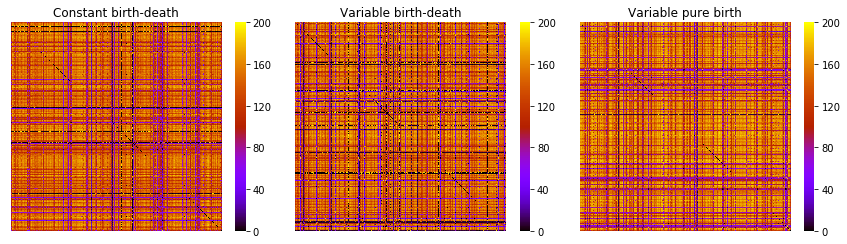

In [22]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5))

sns.heatmap(CBD_df, ax=ax[0], cmap='gnuplot', xticklabels='', yticklabels='')
sns.heatmap(VBD_df, ax=ax[1], cmap='gnuplot', xticklabels='', yticklabels='')
sns.heatmap(VPB_df, ax=ax[2], cmap='gnuplot', xticklabels='', yticklabels='')

ax[0].set_title('Constant birth-death')
ax[1].set_title('Variable birth-death')
ax[2].set_title('Variable pure birth')

plt.tight_layout()

The heatmaps do not show any apparent structure among the gene trees although there appears to be some variation across the three species tree topologies. Preliminary testing showed almost 0 similarity between all gene trees using values of $k$ less than 100.

In [23]:
VBD_a100 = compute_affinity_matrix(D=VBD_RF, kernel_type='adaptive', k=100)
VBD_a250 = compute_affinity_matrix(D=VBD_RF, kernel_type='adaptive', k=250)
CBD_a100 = compute_affinity_matrix(D=CBD_RF, kernel_type='adaptive', k=100)
CBD_a250 = compute_affinity_matrix(D=CBD_RF, kernel_type='adaptive', k=250)
VPB_a100 = compute_affinity_matrix(D=VPB_RF, kernel_type='adaptive', k=100)
VPB_a250 = compute_affinity_matrix(D=VPB_RF, kernel_type='adaptive', k=250)

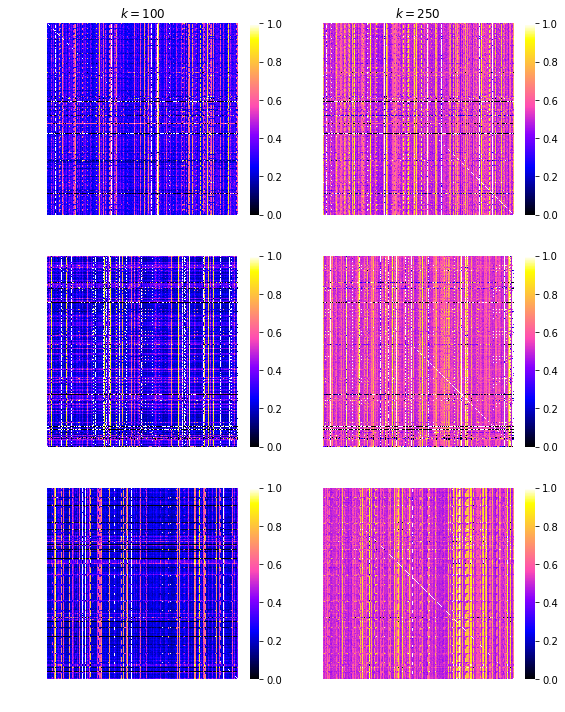

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(8,10))

sns.heatmap(data = pd.DataFrame(CBD_a100), ax=ax[0,0], cmap='gnuplot2')
sns.heatmap(data = pd.DataFrame(CBD_a250), ax=ax[0,1], cmap='gnuplot2')

sns.heatmap(data = pd.DataFrame(VBD_a100), ax=ax[1,0], cmap='gnuplot2')
sns.heatmap(data = pd.DataFrame(VBD_a250), ax=ax[1,1], cmap='gnuplot2')

sns.heatmap(data = pd.DataFrame(VPB_a100), ax=ax[2,0], cmap='gnuplot2')
sns.heatmap(data = pd.DataFrame(VPB_a250), ax=ax[2,1], cmap='gnuplot2')

for i in range(3):
    for j in range(2): ax[i,j].axis('off')
        
ax[0,0].set_ylabel('Constant birth-death')
ax[1,0].set_ylabel('Variable birth-death')
ax[2,0].set_ylabel('Variable pure birth')
ax[0,0].set_title('$k=100$')
ax[0,1].set_title('$k=250$')

plt.tight_layout()

I've chosen $k=250$ for the rest of the analyses to increase the similarity between gene trees in order to increase clustering. 

In [56]:
CBD_clust = greedy_modularity_clustering(affinity=CBD_a250, k=3, merge_tol=0.1, max_iter=10)

			ITERATION 0
		ENTERING PHASE 1
Initial modularity: 0.001779
Merge tolerance: 0.0000000



There are 19 clusters
	Modularity: 0.3950157304
	Modulary increase=0.393236
Merge tolerance: 0.0395016



There are 19 clusters
	Modularity: 0.3950157304
	Modulary increase=0.000000
Reached stationarity
Modularity before iteration: 0.395016
		ENTERING PHASE 2



Modularity after iteration: 0.216903
			ITERATION 1
		ENTERING PHASE 1
Initial modularity: 0.216903
Merge tolerance: 0.0000000



There are 1 clusters
	Modularity: 0.5939775911
	Modulary increase=0.377075
Modularity before iteration: 0.593978
		ENTERING PHASE 2



Modularity after iteration: 0.000000


In [57]:
VBD_clust = greedy_modularity_clustering(affinity=VBD_a250, k=3, merge_tol=0.1, max_iter=10)

In [58]:
VPB_clust = greedy_modularity_clustering(affinity=VPB_a250, k=3, merge_tol=0.1, max_iter=10)

In [112]:
CBD_clustsizes, CBD_modularities = extract_plot_info(final_dict=CBD_clust)
CBD_clustsizes = [len(CBD_a100)] + CBD_clustsizes
CBD_modularities = [0] + CBD_modularities
VBD_clustsizes, VBD_modularities = extract_plot_info(final_dict=VBD_clust)
VBD_clustsizes = [len(VBD_a100)] + VBD_clustsizes
VBD_modularities = [0] + VBD_modularities
VPB_clustsizes, VPB_modularities = extract_plot_info(final_dict=VPB_clust)
VPB_clustsizes = [len(VPB_a100)] + VPB_clustsizes
VPB_modularities = [0] + VPB_modularities

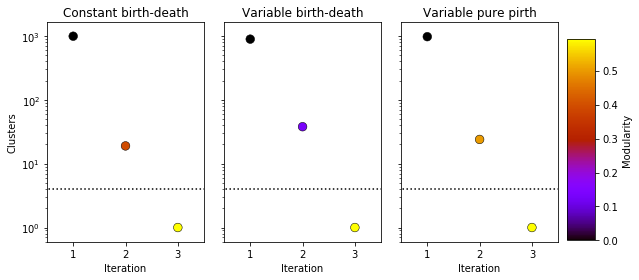

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), sharex=True, sharey=True)

for ax in axes.flat:
    ax.hlines(y=4, xmin=-2, xmax=4, linestyles=':', zorder=1)
    ax.minorticks_on()
    ax.tick_params(axis='x',which='minor',bottom='off')

foo = axes[0].scatter(x=range(len(CBD_clustsizes)), y=CBD_clustsizes, c=CBD_modularities, s=75, 
                      alpha=1, cmap='gnuplot', edgecolors='black', linewidths=0.5)
axes[0].set_title('Constant birth-death')
axes[0].set_ylabel('Clusters')
axes[0].set_xlabel('Iteration')
axes[0].set_xlim([-0.5, 2.5])
axes[0].set_xticklabels(['',1,2,3])
axes[0].semilogy()

axes[1].scatter(x=range(len(VBD_clustsizes)), y=VBD_clustsizes, c=VBD_modularities, s=75, 
                      alpha=1, cmap='gnuplot', edgecolors='black', linewidths=0.5)
axes[1].set_title('Variable birth-death')
axes[1].set_xlabel('Iteration')
axes[2].scatter(x=range(len(VPB_clustsizes)), y=VPB_clustsizes, c=VPB_modularities, s=75, 
                      alpha=1, cmap='gnuplot', edgecolors='black', linewidths=0.5)
axes[2].set_title('Variable pure pirth')
axes[2].set_xlabel('Iteration')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.15, 0.05, 0.7])
fig.colorbar(foo, cax=cbar_ax, label='Modularity')
plt.tight_layout()

Clustering gene trees from all three topologies took three iterations to collapse to a single cluster. My previous modularity clustering method performed best on the second to last iteration, the iteration before all clusters were merged. Gene cluster assignments will be taken from the second iteration.

In [149]:
CBD_assignments = ['CBD']+[str(assignment) for assignment in CBD_clust['i00']['dict']['i01']['clustering'].values()]
VBD_assignments = ['VBD']+[str(assignment) for assignment in VBD_clust['i00']['dict']['i01']['clustering'].values()]
VPB_assignments = ['VPB']+ [str(assignment) for assignment in VPB_clust['i00']['dict']['i01']['clustering'].values()]

In [154]:
assign_df = pd.DataFrame([CBD_assignments, VBD_assignments, VPB_assignments])
assign_df=assign_df.set_index(0).transpose()

In [179]:
CBDcounts = np.array(pd.value_counts(assign_df['CBD'].values, sort=True))
VBDcounts = np.array(pd.value_counts(assign_df['VBD'].values, sort=True))
VPBcounts = np.array(pd.value_counts(assign_df['VPB'].values, sort=True))

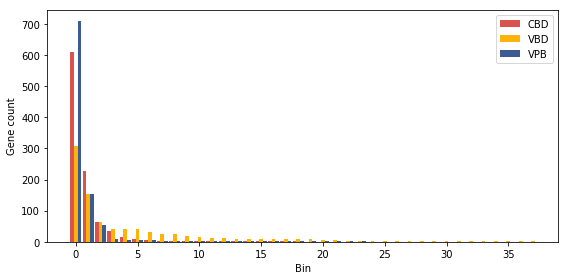

In [213]:
fig, ax = plt.subplots(figsize=(8,4))
ax.bar([x-0.30 for x in range(len(CBDcounts))], CBDcounts, width=0.30, color='xkcd:pale red', label='CBD')
ax.bar(range(len(VBDcounts)), VBDcounts, width=0.30, color='xkcd:amber', label='VBD')
ax.bar([x+0.30 for x in range(len(VPBcounts))], VPBcounts, width=0.30, color='xkcd:denim blue', label='VPB')

ax.set_xlabel('Bin')
ax.set_ylabel('Gene count')

plt.legend()
plt.tight_layout()

The bin counts above show that the variable birth-death topology had a less skewed distribution of gene trees than either the constant birth-death or variable pure birth topology.

In [226]:
CBD_concat_dict = dict()
for k in set(CBD_clust['i00']['dict']['i01']['clustering'].values()):
    CBD_concat_dict[str(k)] = []
for k, v in CBD_clust['i00']['dict']['i01']['clustering'].iteritems():
    filename = './CBD_outfiles/nexus_gfiles/locus'+str(k)+'.nexus'
    CBD_concat_dict[str(v)].append(filename)
VBD_concat_dict = dict()
for k in set(VBD_clust['i00']['dict']['i01']['clustering'].values()):
    VBD_concat_dict[str(k)] = []
for k, v in VBD_clust['i00']['dict']['i01']['clustering'].iteritems():
    filename = './VBD_outfiles/nexus_gfiles/locus'+str(k)+'.nexus'
    VBD_concat_dict[str(v)].append(filename)
VPB_concat_dict = dict()
for k in set(VPB_clust['i00']['dict']['i01']['clustering'].values()):
    VPB_concat_dict[str(k)] = []
for k, v in VPB_clust['i00']['dict']['i01']['clustering'].iteritems():
    filename = './VPB_outfiles/nexus_gfiles/locus'+str(k)+'.nexus'
    VPB_concat_dict[str(v)].append(filename)

In [249]:
for k in CBD_concat_dict.keys():
    file_list = CBD_concat_dict[k]
    
    nexi =  [(fname, Nexus.Nexus(fname)) for fname in file_list]

    combined = Nexus.combine(nexi)
    combined.write_nexus_data(filename=open('./CBD_outfiles/GTCM/'+k+'.nexus', 'w'))

In [251]:
for k in VBD_concat_dict.keys():
    file_list = VBD_concat_dict[k]
    
    nexi =  [(fname, Nexus.Nexus(fname)) for fname in file_list]

    combined = Nexus.combine(nexi)
    combined.write_nexus_data(filename=open('./VBD_outfiles/GTCM/'+k+'.nexus', 'w'))

In [252]:
for k in VPB_concat_dict.keys():
    file_list = VPB_concat_dict[k]
    
    nexi =  [(fname, Nexus.Nexus(fname)) for fname in file_list]

    combined = Nexus.combine(nexi)
    combined.write_nexus_data(filename=open('./VPB_outfiles/GTCM/'+k+'.nexus', 'w'))

In [24]:
CBD_GTCM_nex = [f for f in listabs('./CBD_outfiles/GTCM/') if f.endswith('.nexus')]
VBD_GTCM_nex = [f for f in listabs('./VBD_outfiles/GTCM/') if f.endswith('.nexus')]
VPB_GTCM_nex = [f for f in listabs('./VPB_outfiles/GTCM/') if f.endswith('.nexus')]
GTCM_nex = flatten([CBD_GTCM_nex, VBD_GTCM_nex, VPB_GTCM_nex])

In [27]:
for f in GTCM_nex:
    with open(f, 'a') as n:
        n.writelines(paup_lines)

In [30]:
CBD_GTCM_tre = [re.sub('.nexus', '.tre', f) for f in CBD_GTCM_nex]
VBD_GTCM_tre = [re.sub('.nexus', '.tre', f) for f in VBD_GTCM_nex]
VPB_GTCM_tre = [re.sub('.nexus', '.tre', f) for f in VPB_GTCM_nex]

In [32]:
with open('./ASTRAL/CBD_GTCM.tre', 'w+') as t:
    for f in CBD_GTCM_tre:
        with open(f, 'r') as i:
            t.writelines(i.readlines())

In [33]:
with open('./ASTRAL/VBD_GTCM.tre', 'w+') as t:
    for f in VBD_GTCM_tre:
        with open(f, 'r') as i:
            t.writelines(i.readlines())

In [34]:
with open('./ASTRAL/VPB_GTCM.tre', 'w+') as t:
    for f in VPB_GTCM_tre:
        with open(f, 'r') as i:
            t.writelines(i.readlines())

In [35]:
CBD_bin_tre = [f for f in listabs('./CBD_outfiles/SG_output/nexus_files/') if f.endswith('.tre')]
VBD_bin_tre = [f for f in listabs('./VBD_outfiles/SG_output/nexus_files/') if f.endswith('.tre')]
VPB_bin_tre = [f for f in listabs('./VPB_outfiles/SG_output/nexus_files/') if f.endswith('.tre')]

In [36]:
with open('./ASTRAL/CBD_bin.tre', 'w+') as t:
    for f in CBD_bin_tre:
        with open(f, 'r') as i:
            t.writelines(i.readlines())

In [37]:
with open('./ASTRAL/VBD_bin.tre', 'w+') as t:
    for f in VBD_bin_tre:
        with open(f, 'r') as i:
            t.writelines(i.readlines())

In [38]:
with open('./ASTRAL/VPB_bin.tre', 'w+') as t:
    for f in VPB_bin_tre:
        with open(f, 'r') as i:
            t.writelines(i.readlines())

# TO DO
4. Compare RF distance from all tree to true trees
5. Write short discussion
6. Duplicate file (whole directory)
7. Clean up all but necessary work in the duplicated notebook
8. Remove all but necessary from directory to compress to turn in
9. Try to get a nice looking PDF made of this

## 3 Comparing methods
To measure the performance of my clustering method I compared it to two standard, non-binned, and the only binned approaches. The first, unbinned species tree method employs RAxML (Stamatakis, 2014), a maximum likelihood based method. The input is simply the concatenated sequence data matrix output from ipyrad. Nodal support values were measured with 100 bootstrap replicates. The second unbinned species tree method employs ASTRAL-II (Mirarab and Warnow, 2015). This is a multi-species coalescent based approach based on the Kingman Coalescent (Kingman, 1982a, 1982b). ASTRAL-II takes unrooted gene trees as input (file prep below) and infers all possible unrooted quartets of leaves from each gene tree. It then uses a heuristic search of species tree space to maximize the number of quartets in common between species tree and gene trees. Finally, the naive binning method of Bayzid and Warnow (2013) was applied to each set of gene trees and the resulting gene clusters were concatenated into supergenes before being input into ASTRAL-II. The resulting species trees were compared to the true, simulated tree using the Robinson-Foulds distance.

In [196]:
# Writes files for ATRAL-II; specifically, single tree file with one gene tree per line
with open('allCBD.tre', 'w+') as f:
    for tree in CBD_trees:
        with open(tree, 'r') as t:
            f.write(t.readline())
with open('allVBD.tre', 'w+') as f:
    for tree in VBD_trees:
        with open(tree, 'r') as t:
            f.write(t.readline())
with open('allVPB.tre', 'w+') as f:
    for tree in VPB_trees:
        with open(tree, 'r') as t:
            f.write(t.readline())

The binning method requires a precise file and directory structure. All gene sequence files are converted to '.fasta' format and separated into different directories, each labeled 'genes_dir'.

In [208]:
CBD_nexus = [f.replace('.tre', '.nexus') for f in CBD_trees]
VBD_nexus = [f.replace('.tre', '.nexus') for f in VBD_trees]
VPB_nexus = [f.replace('.tre', '.nexus') for f in VPB_trees]
CBD_fasta = [f.replace('.tre', '.fasta') for f in CBD_trees]
VBD_fasta = [f.replace('.tre', '.fasta') for f in VBD_trees]
VPB_fasta = [f.replace('.tre', '.fasta') for f in VPB_trees]

In [211]:
for f in zip(CBD_nexus, CBD_fasta):
    input_handle = open(f[0], "rU")
    output_handle = open(f[1], "w")

    alignments = AlignIO.parse(input_handle, "nexus")
    AlignIO.write(alignments, output_handle, "fasta")

    output_handle.close()
    input_handle.close()
for f in zip(VBD_nexus, VBD_fasta):
    input_handle = open(f[0], "rU")
    output_handle = open(f[1], "w")

    alignments = AlignIO.parse(input_handle, "nexus")
    AlignIO.write(alignments, output_handle, "fasta")

    output_handle.close()
    input_handle.close()
for f in zip(VPB_nexus, VPB_fasta):
    input_handle = open(f[0], "rU")
    output_handle = open(f[1], "w")

    alignments = AlignIO.parse(input_handle, "nexus")
    AlignIO.write(alignments, output_handle, "fasta")

    output_handle.close()
    input_handle.close()

In [218]:
%%bash
cd CBD_outfiles/
mkdir genes_dir
mv ./nexus_gfiles/*.fasta genes_dir

cd ../VBD_outfiles/
mkdir genes_dir
mv ./nexus_gfiles/*.fasta genes_dir

cd ../VPB_outfiles/
mkdir genes_dir
mv ./nexus_gfiles/*.fasta genes_dir

From here, each locus was given it's own directory along with it's respective gene tree.

In [25]:
for f in listabs('CBD_outfiles/genes_dir/'):
    label = re.split('[/.]', f)[2]
    os.mkdir(label)
    move(f, os.path.join('CBD_outfiles/genes_dir/', label, os.path.basename(f)))

for f in listabs('VBD_outfiles/genes_dir/'):
    label = re.split('[/.]', f)[2]
    os.mkdir(label)
    move(f, os.path.join('VBD_outfiles/genes_dir/', label, os.path.basename(f)))

for f in listabs('VPB_outfiles/genes_dir/'):
    label = re.split('[/.]', f)[2]
    os.mkdir(label)
    move(f, os.path.join(label, os.path.basename(f)))

In [245]:
'\n'.join(paup_lines)

'\nBEGIN PAUP;\n\n\tset autoclose=yes;\n\n\tset increase=auto;\n\n\tNJ breakties=random distance=JC;\n\n\tsavetrees format=Phylip from=1 to=1;\n\n\tquit;\n\nEnd;\n'

In [260]:
newlines = ['\nBEGIN PAUP;\n', 
              '\tset autoclose=yes;\n',
              '\tset increase=auto;\n',
              '\tBootstrap search=fastStep nreps=10;\n',
              '\tsavetrees file=PATH format=Newick supportValues=nodeLabels from=1 to=1;\n', 
              '\tquit;\n', 
              'End;\n']

In [267]:
for nexus in CBD_nexus:
    label = re.split('[/.]', nexus)[-2]
    path = os.path.join('/Users/iangilman/pythonscripts/CBB555/final_proj/CBD_outfiles/genes_dir/', label, 'pauptree.tre')
    finallines = re.sub('PATH', path, ''.join(newlines))
    with open(nexus, 'r+') as f:
        text = f.read()
        text = re.sub(''.join(paup_lines), finallines, text)
        f.seek(0)
        f.write(text)
        f.truncate()
for nexus in VBD_nexus:
    label = re.split('[/.]', nexus)[-2]
    path = os.path.join('/Users/iangilman/pythonscripts/CBB555/final_proj/VBD_outfiles/genes_dir/', label, 'pauptree.tre')
    finallines = re.sub('PATH', path, ''.join(newlines))
    with open(nexus, 'r+') as f:
        text = f.read()
        text = re.sub(''.join(paup_lines), finallines, text)
        f.seek(0)
        f.write(text)
        f.truncate()
for nexus in VPB_nexus:
    label = re.split('[/.]', nexus)[-2]
    path = os.path.join('/Users/iangilman/pythonscripts/CBB555/final_proj/VPB_outfiles/genes_dir/', label, 'pauptree.tre')
    finallines = re.sub('PATH', path, ''.join(newlines))
    with open(nexus, 'r+') as f:
        text = f.read()
        text = re.sub(''.join(paup_lines), finallines, text)
        f.seek(0)
        f.write(text)
        f.truncate()

In [268]:
%%bash
for f in ./{CBD,VBD,VPB}_outfiles/nexus_gfiles/*
do
    paup -n $f
done

Process is terminated.


In [72]:
CBD_SG_fastas = []
CBD_SG_nexus = []
for direc in listabs('./CBD_outfiles/SG_output/'):
    CBD_SG_fastas.append(os.path.join(direc, 'supergene.fasta'))
    label = ''.join(re.split('[/.]', direc)[-3:-1])
    CBD_SG_nexus.append(os.path.join(os.path.split(direc)[0], label+'.nexus'))

In [77]:
for f in zip(CBD_SG_fastas, CBD_SG_nexus):
    input_handle = open(f[0], "rU")
    output_handle = open(f[1], "w")

    alignments = AlignIO.parse(input_handle, "fasta", alphabet=Alphabet.generic_dna)
    AlignIO.write(alignments, output_handle, "nexus")

    output_handle.close()
    input_handle.close()

In [80]:
VBD_SG_fastas = []
VBD_SG_nexus = []
for direc in listabs('./VBD_outfiles/SG_output/'):
    VBD_SG_fastas.append(os.path.join(direc, 'supergene.fasta'))
    label = ''.join(re.split('[/.]', direc)[-3:-1])
    VBD_SG_nexus.append(os.path.join(os.path.split(direc)[0], label+'.nexus'))
for f in zip(VBD_SG_fastas, VBD_SG_nexus):
    input_handle = open(f[0], "rU")
    output_handle = open(f[1], "w")

    alignments = AlignIO.parse(input_handle, "fasta", alphabet=Alphabet.generic_dna)
    AlignIO.write(alignments, output_handle, "nexus")

    output_handle.close()
    input_handle.close()

In [81]:
VPB_SG_fastas = []
VPB_SG_nexus = []
for direc in listabs('./VPB_outfiles/SG_output/'):
    VPB_SG_fastas.append(os.path.join(direc, 'supergene.fasta'))
    label = ''.join(re.split('[/.]', direc)[-3:-1])
    VPB_SG_nexus.append(os.path.join(os.path.split(direc)[0], label+'.nexus'))
for f in zip(VPB_SG_fastas, VPB_SG_nexus):
    input_handle = open(f[0], "rU")
    output_handle = open(f[1], "w")

    alignments = AlignIO.parse(input_handle, "fasta", alphabet=Alphabet.generic_dna)
    AlignIO.write(alignments, output_handle, "nexus")

    output_handle.close()
    input_handle.close()

In [84]:
unpauped_SG = flatten([CBD_SG_nexus, VBD_SG_nexus, VPB_SG_nexus])

In [94]:
unpauped_SG = [os.path.join(os.path.split(filename)[0], 'nexus_files', os.path.split(filename)[1]) for filename in unpauped_SG]

In [95]:
unpauped_SG

['./CBD_outfiles/SG_output/nexus_files/bin0.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin1.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin10.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin100.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin101.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin102.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin103.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin104.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin105.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin106.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin107.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin108.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin109.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin11.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin110.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin111.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin112.nexus',
 './CBD_outfiles/SG_output/nexus_files/bin113.nexus',
 './CBD_outfiles/SG_output/nexus_f

In [96]:
for filename in unpauped_SG:
    if filename.endswith('.nexus'):
        with open(filename, 'a') as n:
            n.writelines(paup_lines)

In [109]:
with open('./raxml/RAxML_bootstrap.CBD', 'r') as f:
    with open('./raxml/RAxML_CBD.tre', 'w+') as t:
        t.writelines(f.readlines()[-1])
with open('./raxml/RAxML_bootstrap.VBD', 'r') as f:
    with open('./raxml/RAxML_VBD.tre', 'w+') as t:
        t.writelines(f.readlines()[-1])
with open('./raxml/RAxML_bootstrap.VPB', 'r') as f:
    with open('./raxml/RAxML_VPB.tre', 'w+') as t:
        t.writelines(f.readlines()[-1])

In [110]:
trueCBD = './CBD.tre'
trueVBD = './VBD.tre'
trueVPB = './VPB.tre'
CBD_ASTRAL = './ASTRAL/CBD_ASTRAL.tre'
VBD_ASTRAL = './ASTRAL/VBD_ASTRAL.tre'
VPB_ASTRAL = './ASTRAL/VPB_ASTRAL.tre'
CBD_bin_ASTRAL = './ASTRAL/CBD_bin.tre' 
VBD_bin_ASTRAL = './ASTRAL/VBD_bin.tre' 
VPB_bin_ASTRAL = './ASTRAL/VPB_bin.tre' 
CBD_GTCM_ASTRAL = './ASTRAL/CBD_GTCM.tre'
VBD_GTCM_ASTRAL = './ASTRAL/VBD_GTCM.tre'
VPB_GTCM_ASTRAL = './ASTRAL/VPB_GTCM.tre'
CBD_raxml = './raxml/RAxML_CBD.tre'
VBD_raxml = './raxml/RAxML_VBD.tre'
VPB_raxml = './raxml/RAxML_VPB.tre'

In [111]:
all_CBD_trees = [CBD_ASTRAL, CBD_bin_ASTRAL, CBD_GTCM_ASTRAL, CBD_raxml]
all_VBD_trees = [VBD_ASTRAL, VBD_bin_ASTRAL, VBD_GTCM_ASTRAL, VBD_raxml]
all_VPB_trees = [VPB_ASTRAL, VPB_bin_ASTRAL, VPB_GTCM_ASTRAL, VPB_raxml]

In [116]:
def RFdist(t1, t2):
    '''A patch to the Robinson-Foulds distance function. Running the naive binning
    software required a different, and incompatible, version of dendropy. This was
    written by Jeet Sukamara, the creator of dendropy.
    
    Parameters
    ----------
    t1 : path to a newick tree
    t2 : path to a newick tree'''
    taxon_namespace = dendropy.TaxonSet()
    lit_tree = dendropy.Tree.get_from_path(
        t1,
        "newick",
        taxon_set=taxon_namespace)
    ml = dendropy.Tree.get_from_path(
        t2,
        "newick",
        taxon_set=taxon_namespace)
    ml.is_rooted
    lit_tree.is_rooted
    ml.symmetric_difference(lit_tree)
    ml.symmetric_difference(lit_tree)
    return lit_tree.symmetric_difference(ml)

In [128]:
CBD_plot_RF = [RFdist(trueCBD, tree) for tree in all_CBD_trees]
VBD_plot_RF = [RFdist(trueVBD, tree) for tree in all_VBD_trees]
VPB_plot_RF = [RFdist(trueVPB, tree) for tree in all_VPB_trees]

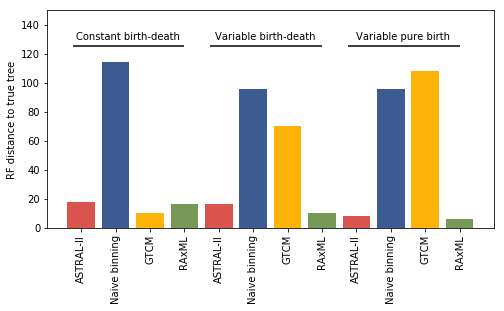

In [177]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(range(12), flatten([CBD_plot_RF, VBD_plot_RF, VPB_plot_RF]), 
       color=['xkcd:pale red', 'xkcd:denim blue', 'xkcd:amber', 'xkcd:moss']*3)
ax.set_xticks(range(12))
ax.set_xticklabels(['ASTRAL-II', 'Naive binning', 'GTCM', 'RAxML']*3, rotation='vertical')
ax.set_ylim([0, 150])
ax.hlines(y=125, xmin=-0.25, xmax=3.)
ax.hlines(y=125, xmin=3.75, xmax=7.)
ax.hlines(y=125, xmin=7.75, xmax=11)
ax.text(x=-0.15, y=130, s='Constant birth-death')
ax.text(x=3.90, y=130, s='Variable birth-death')
ax.text(x=8, y=130, s='Variable pure birth')
ax.set_ylabel('RF distance to true tree')

## 4. Discussion
Only in the constant birth-death topology was the gene tree clusting with modularity. (GTCM) method most accurate. In general, both binning methods performed worse than using all genes individually or concatenating them. This runs contrary to the findings of Bayzid and Warnow (2013) and Mirarab et al. (2014). This is not immediately surprising, givien that a number of methodological short cuts were taken in the binning analyses. 

The major source of error in the binning analyses is that they rely on multiple rounds of gene tree and supergene tree construction through neighbor-joining. As mentioned above, neighbor-joining was employed because of its low computational cost, which comes at the expense of phylogenetic rigor. Although the non-binned ASTRAL-II analyses incorporated neighbor-joined gene trees, previous work (Gilman and Tank, *in review*) has shown that most short, RADseq loci best fit a simple model of sequence evolution such as the Jukes-Cantor (JC) model, which was used as the neighbor-joinging distance metric. Therefore, the use of neighbor-joining under the JC model to construct initial gene trees probably did not dramatically violate the assumptions of neighbor-joing tree construction. However, after clustering (binning) loci into supergenes, the assumption that a simple model of sequence evolution, with no likelihood or Bayesian analysis, would produce an accurate supergene tree was probably unwarranted.

A second complication in the interpretation of these results is that they have not been replicated to gauge the variation in performance. Although there are relatively straightforward pipelines for commonly employed programs such as ASTRAL-II and RAxML with standard datasets, the added step of clustering genes is computationally expensive and still ad hoc, even for the published method of Bayzid et al. (2013). Furthermore, the vast parameter space spanning simulations, gene tree construction, clustering, and species tree construction is not practically explorable. Here, I presented a small study into clustering gene trees under very limited scenarios, but further work into better parameterizing the clustering method is needed.

Despite these caveats, clustering loci will likely still play an important role in phylogenomics. Some of the most computationally taxing problems in species tree analyses concern construction species trees from single, enormous data matrices and from many, small matrices. Clustering sequence data into moderate chunks can therefore greatly ease the computational burderns of these analyses (e.g. analyzing full avian genomes, Mirarab et al., 2014). In addition, concatenating data with low, but congruent, signal can amplify that signal. Another lucrative path of study is the affect of cluster sizes on species tree accuracy. The GTCM methods showed a very skewed relationship, in which most loci clustered into a handful of bins, which the naive binning approach (which has been shown to increase species tree accuracy) 

In addition to the long-known discordant signal throughout individual genomes, it has recently been observed that some controversial phylogenetic relationships rely on support from as few as a single locus (Shen et al. 2017). These pieces of information suggest that extreme loci deserve more scrutiny. Gene clustering may be used for identifying these unique loci through the diparity in cluster sizes, and particularly in loci that form singletons. It may also prove useful in identification of paralogous genes (which may form significantly denser clusters) or contaminant genomic fragments (which may form clusters that are less connected to true genomic clusters). 

In conclusion, clustering genes for species tree analysis is a rich and under-explored branch of computational biology. In it's lowest realization it may improve the computational efficiency of species tree programs, but at best it will increase the accuracy and precision of species tree inference. I show, in a limited study, that there are conditions in which clustering gene trees using a greed modularity algorithm can improve the accuracy of species tree construction. Further work to better parameterize and utilize clustering will surely improve species tree estimation.

## 5. References
* Baird, N. A., Etter, P. D., Atwood, T. S., Currey, M. C., Shiver, A. L., Lewis, Z. A., et al. (2008). Rapid SNP Discovery and Genetic Mapping Using Sequenced RAD Markers. PLoS ONE, 3(10), e3376–17.
* Bayzid, M. S., & Warnow, T. (2013). Naive binning improves phylogenomic analyses. Bioinformatics, 29(18), 2277–2284.
* Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 2008(10), P10008–13.
* Eaton, D. A. R. (2014). PyRAD: assembly of de novo RADseq loci for phylogenetic analyses. Bioinformatics, 30(13), 1844–1849.
* Eaton, D. A. R., Spriggs, E. L., Park, B., & Donoghue, M. J. (2017). Misconceptions on Missing Data in RAD-seq Phylogenetics with a Deep-scale Example from Flowering Plants. Systematic Biology, 66(3), 399–412.
* Jarvis, E. D., Mirarab, S., Aberer, A. J., Li, B., Houde, P., Li, C., et al. (2014). Whole-genome analyses resolve early branches in the tree of life of modern birds. Science, 346(6215), 1320–1331.
* Jukes, T. H., & Cantor, C. R. (1969). Evolution of Protein Molecules. Mammalian Protein Metabolism (pp. 21–132). Elsevier.
* Kingman, J. F. C. (1982). The coalescent. Stochastic Processes and Their Applications, 13(3), 235–248.
* Kingman, J. F. C. (1982). On the genealogy of large populations. Journal of Applied Probability, 19(A), 27–43.
* Maddison, W. P. (1997). Gene trees in species trees. Systematic Biology, 46(3), 523–536.
* Mirarab, S., Bayzid, M. S., Boussau, B., & Warnow, T. (2014). Statistical binning enables an accurate coalescent-based estimation of the avian tree. Science, 346(6215), 1250463–1250463.
* Mirarab, S., & Warnow, T. (2015). ASTRAL-II: coalescent-based species tree estimation with many hundreds of taxa and thousands of genes. Bioinformatics, 31(12), i44–i52.
* Robinson, D. F., & Foulds, L. R. (1981). Comparison of phylogenetic trees. Mathematical Biosciences, 53(1-2), 131–147. 
* Roch, S., & Steel, M. (2014). Likelihood-based tree reconstruction on a concatenation of aligned sequence data sets can be statistically inconsistent. Theoretical Population Biology, 100C, 56–62.
* Shen, X.-X., Hittinger, C. T., & Rokas, A. (2017). Contentious relationships in phylogenomic studies can be driven by a handful of genes. Nature Ecology & Evolution, 1(5), 1–10.
* Stamatakis, A. (2014). RAxML version 8: a tool for phylogenetic analysis and post-analysis of large phylogenies. Bioinformatics, 30(9), 1312–1313.
* Swofford, D. L. 2002. PAUP*. Phylogenetic Analysis Using Parsimony (*and Other Methods). Version 4. Sinauer Associates, Sunderland, Massachusetts.